<a href="https://colab.research.google.com/github/CaptaiN785/DL-Notebooks/blob/main/Image-classification-with%20bounding-box/BoundingBoxregression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [303]:
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import glob
import cv2 as cv
import pandas as pd
import os
!pip install xmltodict
import xmltodict
from PIL.Image import fromarray
from PIL import ImageDraw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [304]:
zip = zipfile.ZipFile("archive.zip")
zip.extractall()
zip.close()

In [305]:
data_path = "training_images"

In [306]:
## Creating the dataframe of image with their xml file
name_dict = {}
for file in os.listdir(data_path):
    name = file.split(".")[0]
    if name in name_dict:
        name_dict[name] += 1
    else:
        name_dict[name] = 1

In [307]:
## Here one image is missing
## Finding the one images

In [308]:
names = []
for name, count in name_dict.items():
    if count == 2:
        names.append(name)
    else:
        print(name)

training_images


In [309]:
len(names)

186

In [310]:
len(os.listdir(data_path))

373

In [311]:
images = []
xmins = []
ymins = []
widths = []
heights = []
classes = []
for name in names:
    img = cv.resize(cv.imread(os.path.join(data_path, name+".jpg")), (228, 228))
    img = np.array(img, dtype='int')
    images.append(img)

    cls = name.split('_')[0]
    classes.append(cls)

    fl = xmltodict.parse(open(os.path.join(data_path, name+".xml"), "rb"))
    xmin = int(fl['annotation']['object']['bndbox']['xmin'])
    ymin = int(fl['annotation']['object']['bndbox']['ymin'])
    width = int(fl['annotation']['object']['bndbox']['xmax']) - xmin
    height = int(fl['annotation']['object']['bndbox']['ymax']) - ymin

    xmins.append(xmin)
    ymins.append(ymin)
    widths.append(width)
    heights.append(height)

In [312]:
df = pd.DataFrame({'class':classes, 'xmin':xmins, 
                   'ymin':ymins, 'width':widths, 'height':heights, 'name':names})


In [313]:
df.head()

,class,xmin,ymin,width,height,name
0,mushroom,49,86,134,99,mushroom_20
1,eggplant,49,37,143,135,eggplant_11
2,eggplant,20,72,191,80,eggplant_32
3,cucumber,13,129,183,41,cucumber_24
4,cucumber,78,17,75,200,cucumber_7


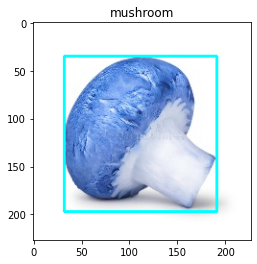

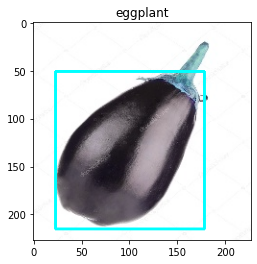

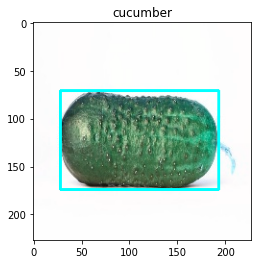

In [314]:
def print_class(df, cls):
    ind = df[df['class']==cls].sample(1).index
    row = df.iloc[ind].values[0]
    img = cv.imread(os.path.join(data_path, row[5]+".jpg"))
    cv.rectangle(img, (row[1], row[2]), (row[1]+row[3], row[2]+row[4]), (0,255, 255), 2)
    plt.title(row[0])
    plt.imshow(img)
    plt.show()
for cls in df['class'].unique():
    print_class(df, cls)

In [315]:
from sklearn.preprocessing import LabelBinarizer

In [316]:
## Creating the dependent and independent features

In [317]:
bn = LabelBinarizer()
classes = bn.fit_transform(df['class'])

In [318]:
bbox = df[['xmin', 'ymin','width', 'height']].values/288

In [319]:
X = np.array(images)
Y = np.concatenate([classes, bbox], axis = 1)

In [320]:
Y = Y.astype('float')

In [321]:
## Normalizing the image
X = X/255.0

In [322]:
## Now splitting the train and test split
from sklearn.model_selection import train_test_split

In [323]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((167, 228, 228, 3), (167, 7), (19, 228, 228, 3), (19, 7))

In [324]:
### Now creating the function to calculate the Intersection over Union
from tensorflow.keras import backend
from tensorflow.keras.losses import mean_squared_error
import tensorflow

In [325]:
tensorflow.function
def calculate_iou(target, pred):
    print(target, pred)
    xA = backend.maximum(target[:,0], pred[:,0])
    yA = backend.maximum(target[:,1], pred[:,1])
    xB = backend.minimum(target[:,2], pred[:,2])
    yB = backend.minimum(target[:,3], pred[:,3])
    interArea = backend.maximum(0.0, xB-xA)*backend.maximum(0.0,yB-yA)
    boxAarea = (target[:,2]-target[:,0])*(target[:,3]-target[:,1])
    boxBarea = (pred[:,2]-pred[:,0]) * (pred[:,3]-pred[:,1])
    
    iou = interArea / (boxAarea+boxBarea - interArea)
    return iou

tensorflow.function
def custom_loss(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    iou = calculate_iou(y_true , y_pred)
    return mse + (1-iou)
tensorflow.function
def iou_metric(y_true, y_pred):
    return calculate_iou(y_true, y_pred)

In [326]:
## Now Buildig the model

In [327]:
## Defining the parameters
input_shape = ( 228 , 228 , 3 )
dropout_rate = 0.5
classes = 3
alpha = 0.2
prediction_units = 4+ classes

In [328]:
from tensorflow.keras import layers
from tensorflow.keras import models

In [329]:
model = models.Sequential([
    layers.Input(shape=input_shape),

    layers.Conv2D(16, (3, 3)),
    layers.LeakyReLU(alpha),
    layers.Conv2D(16, (3, 3)),
    layers.LeakyReLU(alpha),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(32, (3, 3)),
    layers.LeakyReLU(alpha),
    layers.Conv2D(32, (3, 3)),
    layers.LeakyReLU(alpha),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3)),
    layers.LeakyReLU(alpha),
    layers.Conv2D(64, (3, 3)),
    layers.LeakyReLU(alpha),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3)),
    layers.LeakyReLU(alpha),
    layers.Conv2D(128, (3, 3)),
    layers.LeakyReLU(alpha),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3)),
    layers.LeakyReLU(alpha),
    layers.Conv2D(256, (3, 3)),
    layers.LeakyReLU(alpha),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    layers.Dense(1240),
    layers.LeakyReLU(alpha),

    layers.Dense(640),
    layers.LeakyReLU(alpha),
    
    layers.Dense(480),
    layers.LeakyReLU(alpha),
    
    layers.Dense(120),
    layers.LeakyReLU(alpha),
    
    layers.Dense(64),
    layers.LeakyReLU(alpha),
    
    layers.Dense(prediction_units)
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 226, 226, 16)      448       
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 226, 226, 16)      0         
                                                                 
 conv2d_21 (Conv2D)          (None, 224, 224, 16)      2320      
                                                                 
 leaky_re_lu_31 (LeakyReLU)  (None, 224, 224, 16)      0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 110, 110, 32)      4640      
                                                      

In [330]:
from tensorflow.keras.optimizers import Adam

In [331]:
model.compile(
    optimizer= Adam(1e-4),
    loss=custom_loss,
    metrics=[iou_metric]
)

In [332]:
from tensorflow.keras.callbacks import ModelCheckpoint

filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [333]:
history = model.fit( 
    X_train ,
    y_train , 
    validation_data=( X_test , y_test ),
    epochs=100 ,
    batch_size=3,
    callbacks=[checkpoint]
)

Epoch 1/100
Tensor("IteratorGetNext:1", shape=(None, 7), dtype=float32) Tensor("sequential_2/dense_17/BiasAdd:0", shape=(None, 7), dtype=float32)
Tensor("IteratorGetNext:1", shape=(None, 7), dtype=float32) Tensor("sequential_2/dense_17/BiasAdd:0", shape=(None, 7), dtype=float32)
Tensor("IteratorGetNext:1", shape=(None, 7), dtype=float32) Tensor("sequential_2/dense_17/BiasAdd:0", shape=(None, 7), dtype=float32)
Tensor("IteratorGetNext:1", shape=(None, 7), dtype=float32) Tensor("sequential_2/dense_17/BiasAdd:0", shape=(None, 7), dtype=float32)
56/56 [==============================] - ETA: 0s - loss: 1.1264 - iou_metric: 0.0000e+00Tensor("IteratorGetNext:1", shape=(None, 7), dtype=float32) Tensor("sequential_2/dense_17/BiasAdd:0", shape=(None, 7), dtype=float32)
Tensor("IteratorGetNext:1", shape=(None, 7), dtype=float32) Tensor("sequential_2/dense_17/BiasAdd:0", shape=(None, 7), dtype=float32)

Epoch 1: val_loss improved from inf to 1.10580, saving model to model-ep001-loss1.126-val_loss1

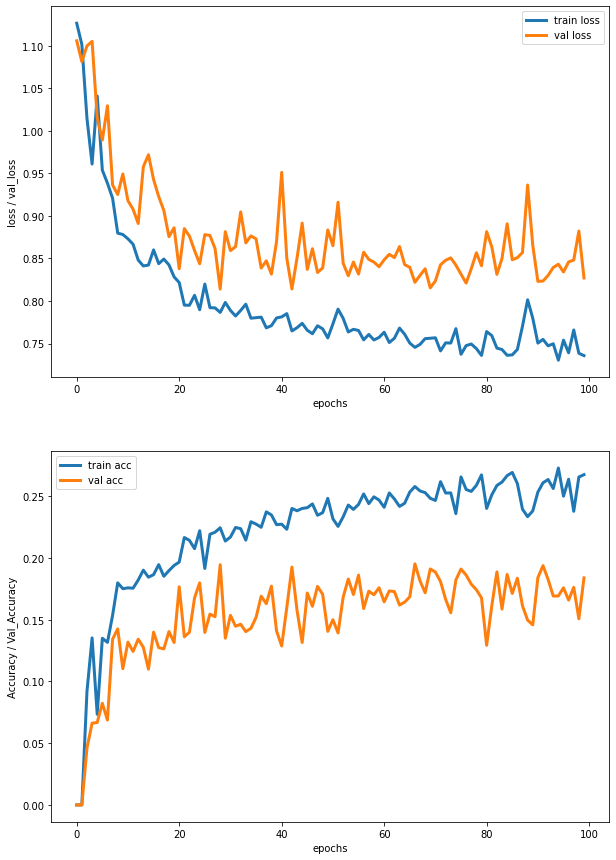

In [334]:
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['iou_metric']
val_acc = history.history['val_iou_metric']


plt.figure(figsize=(10,15))
plt.subplot(2,1,1)
plt.plot(loss , linewidth=3 ,label='train loss')
plt.plot(val_loss , linewidth=3, label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss / val_loss')
plt.legend()

plt.subplot(2,1,2)
plt.plot(acc , linewidth=3 ,label='train acc')
plt.plot(val_acc , linewidth=3, label='val acc')
plt.xlabel('epochs')
plt.ylabel('Accuracy / Val_Accuracy')
plt.legend()

In [335]:
## Now checking the model on testing images
import tensorflow as tf

In [356]:
def draw_image(model,image, y_true, le):
    img = tf.cast(np.expand_dims(image, axis=0), tf.float32)
    y_true = np.expand_dims(y_true, axis=0)
    
    #prediction
    predict = model.predict(img, verbose=None)
    
    # print(y_true, predict)

    #Box coordinates
    Y_test_box =y_true[0,3:]*288
    pred_box = predict[0,3:]*288

    x = pred_box[0]
    y = pred_box[1]
    w = pred_box[2] + x
    h = pred_box[3] + y
    #get class name
    trans= le.inverse_transform(predict[:, 0:4])
    y_true_label = le.inverse_transform(y_true)[0]

    im = fromarray((image*255).astype(np.uint8))
    draw=ImageDraw.Draw(im)
    draw.rectangle([x,y,w,h], outline='cyan', width=2)
    plt.title("P: "+trans[0] + " A: " + y_true_label)
    plt.imshow(im)
    plt.axis('off')

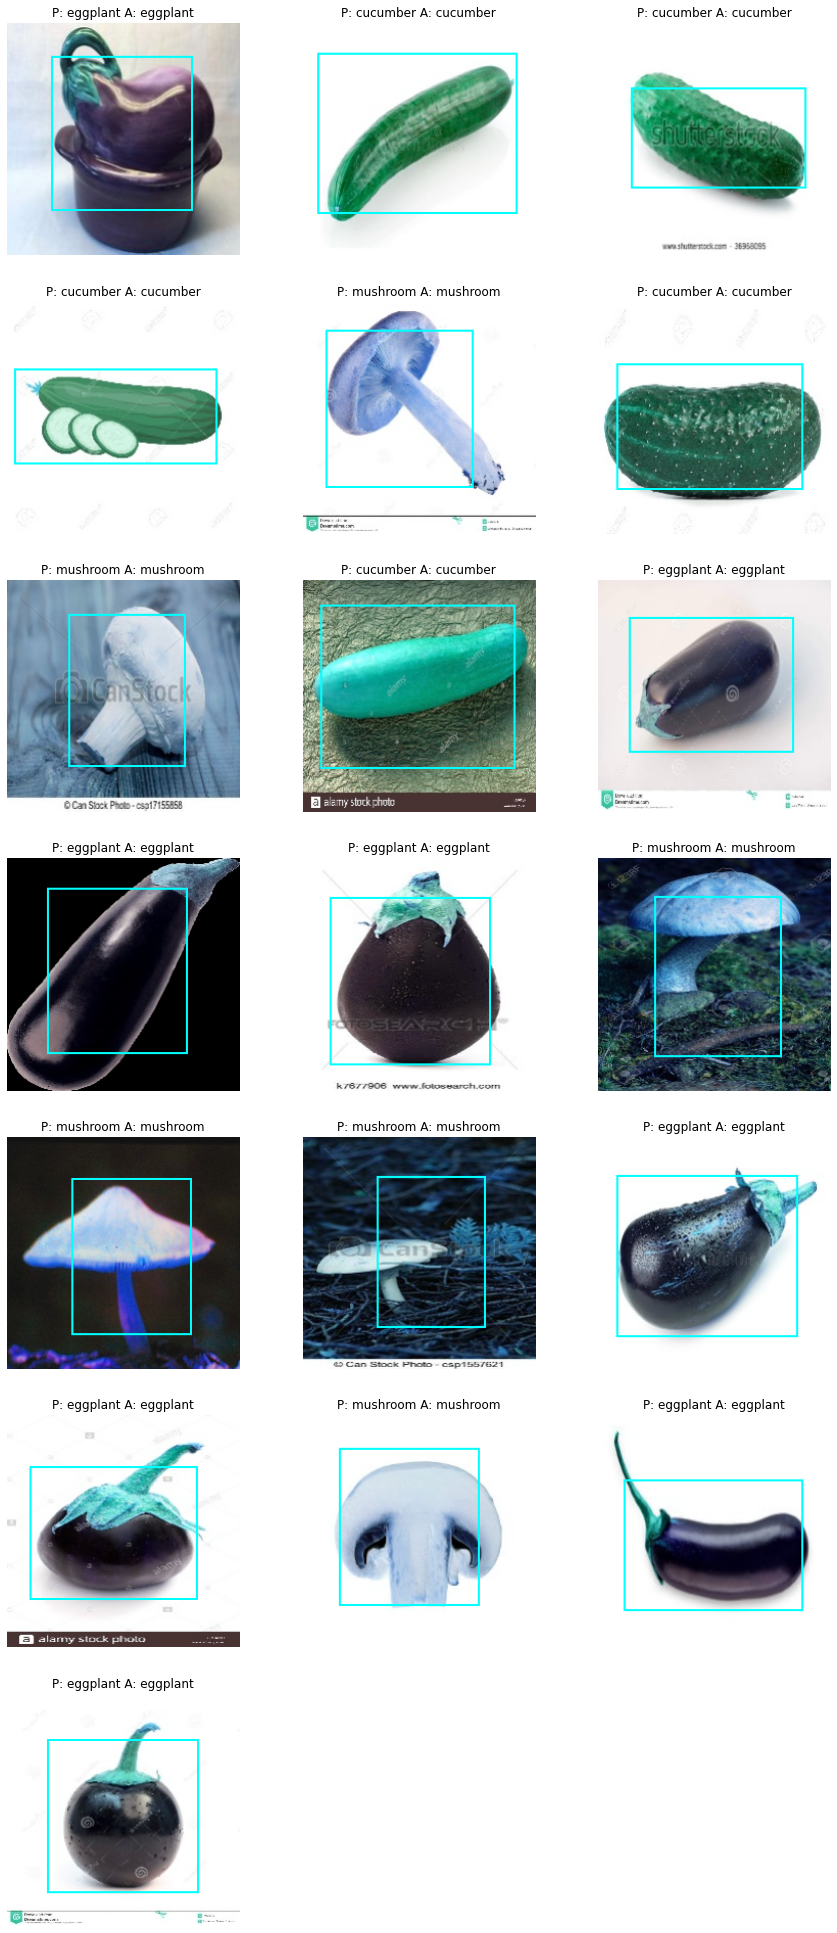

In [357]:
plt.figure(figsize=(15, 35))
for i in range(X_test.shape[0]):
    plt.subplot(7, 3, i+1)
    draw_image(model, X_test[i], y_test[i], bn)
plt.show()